In [126]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.tools.plotting import scatter_matrix
from ast import literal_eval 
import datetime

# analysis
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

In [109]:
datetime.datetime.now().year

2016

In [65]:
bizcsv.head()

,attributes.Ambience.divey,attributes.Dietary Restrictions.vegan,attributes.Happy Hour,hours.Thursday.open,attributes.Order at Counter,attributes.Hair Types Specialized In.africanamerican,attributes.Hair Types Specialized In.kids,attributes.BYOB,hours.Friday.open,attributes.Good For.latenight,...,attributes.Noise Level,attributes.Smoking,attributes.Attire,attributes.Hair Types Specialized In.curly,attributes.Good For Groups,neighborhoods,attributes.Open 24 Hours,attributes.Ambience.romantic,attributes.Music.jukebox,attributes.Ambience.upscale
0,False,NaN,NaN,11:00,NaN,NaN,NaN,NaN,11:00,False,...,average,NaN,casual,NaN,True,[],NaN,False,NaN,False
1,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,[],NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,10:00,NaN,NaN,NaN,NaN,10:00,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [3]:
users = pd.read_csv('data/yelp_academic_dataset_user.csv')

In [17]:
users.columns

Index([u'yelping_since', u'compliments.plain', u'review_count', u'friends',
       u'compliments.cute', u'compliments.writer', u'fans',
       u'compliments.note', u'type', u'compliments.hot', u'compliments.cool',
       u'compliments.profile', u'average_stars', u'compliments.more', u'elite',
       u'name', u'user_id', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful'],
      dtype='object')

In [18]:
users['type'].value_counts()

user    552339
Name: type, dtype: int64

In [16]:
users.sort_values(by='review_count', ascending = False).head()

,yelping_since,compliments.plain,review_count,friends,compliments.cute,compliments.writer,fans,compliments.note,type,compliments.hot,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
230389,2007-12,2459,10320,"['8J4IIYcqBlFch8T90N923A', '-_1ctLaz3jhPYc12hK...",50,1704,520,1337,user,1702,...,173,"[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]",Victor,JLM36sYWmouJAZ2knzst7A,28731,70,26957,46,659,40669
15207,2010-10,123,8529,"['jlpbR7IurKHCnSrGxELVlg', 'AP3dViTwzQTZAJKePu...",4,67,98,72,user,71,...,12,"[2012, 2013, 2014, 2015]",Shila,1p3d__fuRRCDXfbS1Tq0wA,1651,7,2237,4,33,4437
120448,2011-06,354,5833,"['6Wuwx_PAlXmcCJA0tinQ0A', 'VanRbQVUDRBxDsWso2...",1,56,129,147,user,74,...,34,[],Kenneth,3zBKfA8-_fJRagWSTMLVvg,2995,1,2280,44,236,5239
161097,2009-03,1095,5648,"['rpOyqD_893cqmDAtJLbdog', '-_1ctLaz3jhPYc12hK...",5,492,151,373,user,436,...,85,"[2010, 2011, 2012, 2013, 2014, 2015]",Bruce,VhI6xyylcAxi0wOy2HOX3w,21030,19,18955,549,357,24840
252143,2009-11,2648,5050,"['nADIxfovhb5Dj6nPoZwHGg', 'mAuBHENS_DeFCQqrJC...",50,336,318,854,user,477,...,134,"[2009, 2010, 2011, 2012, 2013, 2014, 2015]",Jennifer,22-6yC05pgWbLupHZTjQig,8473,85,7368,723,708,13212


In [19]:
users.head()

,yelping_since,compliments.plain,review_count,friends,compliments.cute,compliments.writer,fans,compliments.note,type,compliments.hot,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,25,108,"['rpOyqD_893cqmDAtJLbdog', '4U9kSBLuBDU391x6bx...",15,9,70,20,user,48,...,3,"[2005, 2006]",Russel,18kPq7GPye-YQ3LyKyAZPw,245,NaN,167,14,11,280
1,2004-10,959,1274,"['18kPq7GPye-YQ3LyKyAZPw', '4U9kSBLuBDU391x6bx...",206,327,1179,611,user,1094,...,134,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38,7681,330,580,14199
2,2004-10,89,442,"['18kPq7GPye-YQ3LyKyAZPw', 'rpOyqD_893cqmDAtJL...",23,24,100,83,user,101,...,19,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Michael,4U9kSBLuBDU391x6bxU-YA,732,4,908,24,120,1483
3,2004-10,NaN,11,"['18kPq7GPye-YQ3LyKyAZPw', 'rpOyqD_893cqmDAtJL...",2,NaN,2,NaN,user,NaN,...,NaN,[],Ken,fHtTaujcyKvXglE33Z5yIw,5,NaN,1,NaN,NaN,11
4,2004-10,2,66,"['rpOyqD_893cqmDAtJLbdog', 'HDQixQ-WZEV0LVPJlI...",2,2,4,1,user,1,...,1,[2005],Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34


In [20]:
users.columns

Index([u'yelping_since', u'compliments.plain', u'review_count', u'friends',
       u'compliments.cute', u'compliments.writer', u'fans',
       u'compliments.note', u'type', u'compliments.hot', u'compliments.cool',
       u'compliments.profile', u'average_stars', u'compliments.more', u'elite',
       u'name', u'user_id', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful'],
      dtype='object')

In [23]:
# add total votes and compliments
voteslist = [col for col in list(users.columns) if 'votes' in col]
compslist = [col for col in list(users.columns) if 'compliments' in col]
users['votes'] = users[voteslist].sum(axis = 1)
users['comps'] = users[compslist].sum(axis = 1)

In [41]:
# add total elite years
users.elite = users.elite.apply(lambda x: literal_eval(x)) # don't rerun this
users['elite_yrs'] = users.elite.apply(lambda x: len(x))

In [55]:
# add total friends
users.friends = users.friends.apply(lambda x: literal_eval(x)) # don't rerun this
users['friends_num'] = users.friends.apply(lambda x: len(x))

In [96]:
# add elite yes/no
users['is_elite'] = users.elite.apply(lambda x: 1 if len(x) > 0 else 0)

In [118]:
# add time on yelp
users['yelping_since'] = pd.to_datetime(users.yelping_since)
users['yrs_yelping'] = users.yelping_since.apply(
    lambda x: datetime.datetime.now().year - x.year)

In [117]:
type(datetime.datetime.now().year)

int

In [119]:
users.head()

,yelping_since,compliments.plain,review_count,friends,compliments.cute,compliments.writer,fans,compliments.note,type,compliments.hot,...,comps,elite_yrs,friends_num,is_elite,review_count_log,friends_num_log,votes_log,comps_log,elite_yrs_log,yrs_yelping
0,2004-10-01,25,108,"[rpOyqD_893cqmDAtJLbdog, 4U9kSBLuBDU391x6bxU-Y...",15,9,70,20,user,48,...,231,2,202,1,4.682131,5.308268,6.539586,5.442418,0.693147,12
1,2004-10-01,959,1274,"[18kPq7GPye-YQ3LyKyAZPw, 4U9kSBLuBDU391x6bxU-Y...",206,327,1179,611,user,1094,...,6037,11,1936,1,7.149917,7.568379,10.403444,8.705662,2.397895,12
2,2004-10-01,89,442,"[18kPq7GPye-YQ3LyKyAZPw, rpOyqD_893cqmDAtJLbdo...",23,24,100,83,user,101,...,641,11,405,1,6.091310,6.003887,8.046549,6.463029,2.397895,12
3,2004-10-01,NaN,11,"[18kPq7GPye-YQ3LyKyAZPw, rpOyqD_893cqmDAtJLbdo...",2,NaN,2,NaN,user,NaN,...,2,0,4,0,2.397895,1.386294,2.833213,0.693147,-6.907755,12
4,2004-10-01,2,66,"[rpOyqD_893cqmDAtJLbdog, HDQixQ-WZEV0LVPJlIGQe...",2,2,4,1,user,1,...,10,1,4,1,4.189655,1.386294,4.060443,2.302585,0.000000,12


In [141]:
# log transform variables
def log_transform(stat):
    if stat > 0:
        return np.log(stat)
    elif stat == 0:
        return np.log(stat + .001)
    else:
        return np.log(1 + stat)
    
users['review_count_log'] = users.review_count.apply(log_transform)
users['friends_num_log'] = users.friends_num.apply(log_transform)
users['votes_log'] = users.votes.apply(log_transform)
users['comps_log'] = users.comps.apply(log_transform)
users['elite_yrs_log'] = users.elite_yrs.apply(log_transform)
users['fans_log'] = users.fans.apply(log_transform)

In [143]:
# logistic regression
log_features = ['yrs_yelping', 'review_count_log', 'fans_log',
                'friends_num_log', 'votes_log', 'comps_log', 'average_stars']
Xtrain, Xtest, ytrain, ytest = train_test_split(
    users[log_features], users.is_elite, test_size = .25)

In [144]:
log_model = LogisticRegression()
log_model = log_model.fit(Xtrain, ytrain)
pred_log = log_model.predict(Xtest)
print 'accuracy score: ', accuracy_score(ytest, pred_log)

accuracy score:  0.975696129196


In [145]:
print zip(log_features, [i for sl in log_model.coef_.tolist() for i in sl])

[('yrs_yelping', -0.19356659381186528), ('review_count_log', 1.37543113494199), ('fans_log', 0.07320326948372215), ('friends_num_log', 0.09668255505052338), ('votes_log', 0.16054908377562138), ('comps_log', 0.6768890263188191), ('average_stars', 0.481507651473828)]


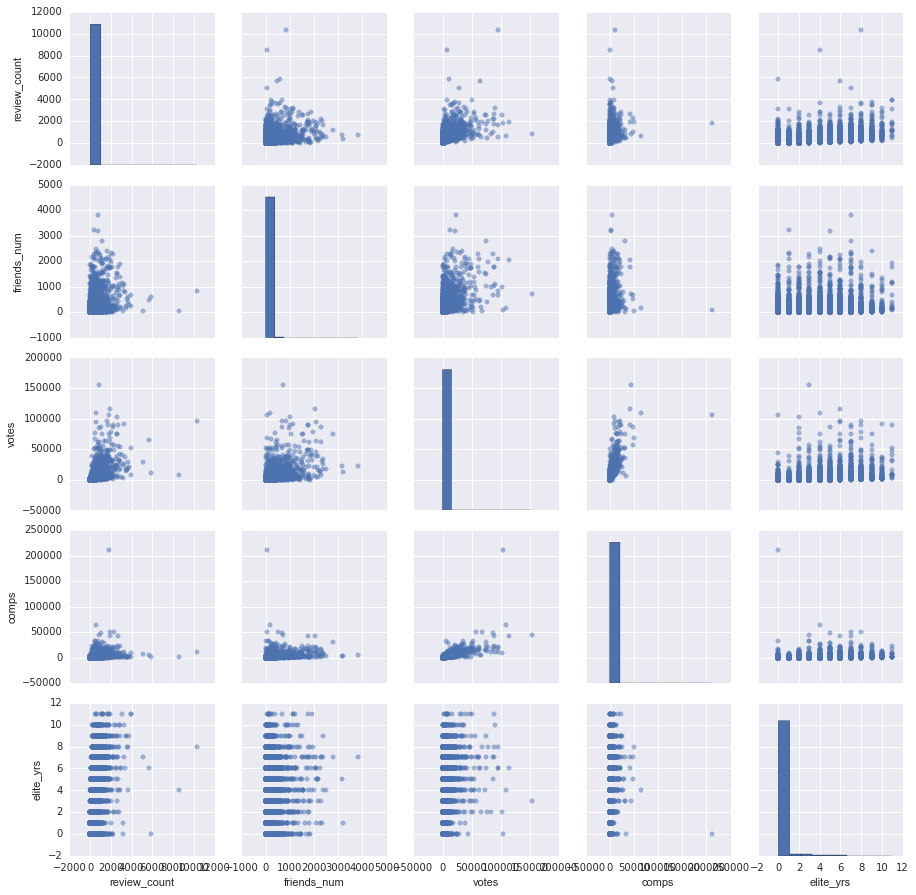

In [71]:
features = ['review_count', 'friends_num', 'votes', 'comps', 'elite_yrs']
plot = sns.PairGrid(u[features])
plot.map_diag(plt.hist)
plot.map_upper(plt.scatter, alpha = 0.5)
plot.map_lower(plt.scatter, alpha = 0.5);

In [80]:
def log_transform(stat):
    if stat > 0:
        return np.log(stat)
    elif stat == 0:
        return np.log(stat + .001)
    else:
        return np.log(1 + stat)

In [83]:
u['review_count_log'] = u.review_count.apply(log_transform)
u['friends_num_log'] = u.friends_num.apply(log_transform)
u['votes_log'] = u.votes.apply(log_transform)
u['comps_log'] = u.comps.apply(log_transform)
u['elite_yrs_log'] = u.elite_yrs.apply(log_transform)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

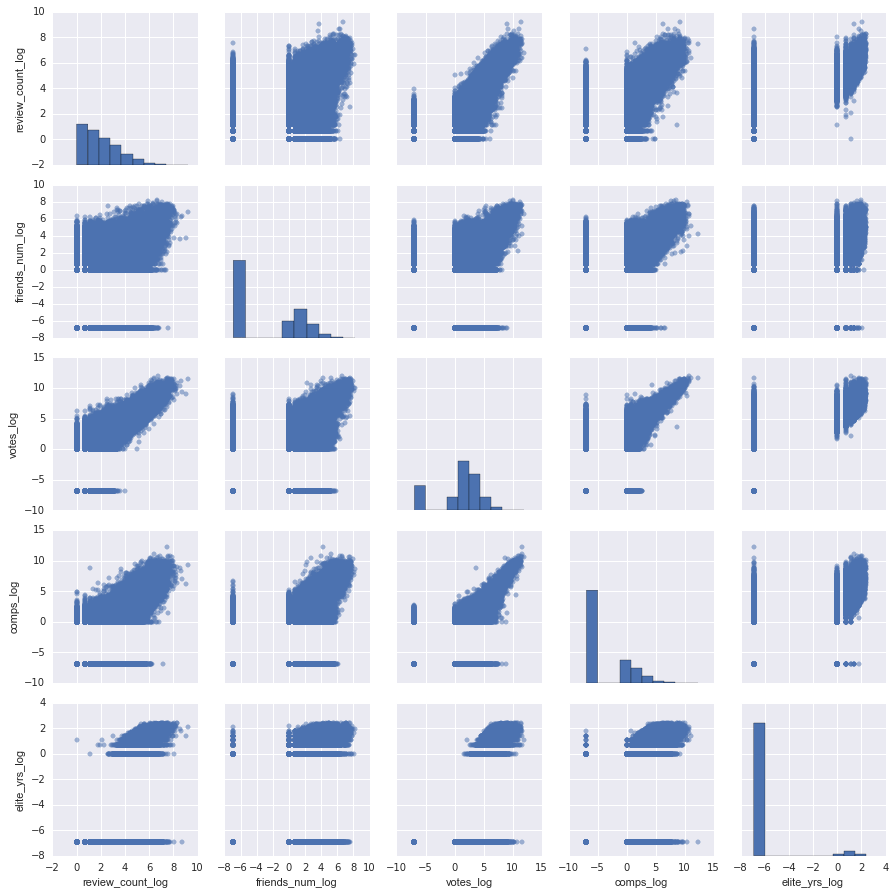

In [84]:
log_features = ['review_count_log', 'friends_num_log', 
                'votes_log', 'comps_log', 'elite_yrs_log']
plot = sns.PairGrid(u[log_features])
plot.map_diag(plt.hist)
plot.map_upper(plt.scatter, alpha = 0.5)
plot.map_lower(plt.scatter, alpha = 0.5);

In [93]:
ys = ['friends_num_log', 'votes_log', 'comps_log', 'elite_yrs_log']

scores = []
for i in ys:  
    X = u.review_count_log
    y = u[i]
    m = sm.OLS(y, X)
    m = m.fit()
    scores.append(m.rsquared)

print zip(ys, scores)

[('friends_num_log', 0.059813958743482387), ('votes_log', 0.37312353481806337), ('comps_log', 0.061463678374059416), ('elite_yrs_log', 0.45580717865596876)]


In [94]:
u.columns

Index([u'yelping_since', u'compliments.plain', u'review_count', u'friends',
       u'compliments.cute', u'compliments.writer', u'fans',
       u'compliments.note', u'type', u'compliments.hot', u'compliments.cool',
       u'compliments.profile', u'average_stars', u'compliments.more', u'elite',
       u'name', u'user_id', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful', u'votes',
       u'comps', u'elite_yrs', u'friends_num', u'review_count_log',
       u'friends_num_log', u'votes_log', u'comps_log', u'elite_yrs_log'],
      dtype='object')

In [ ]:
'''
- add total votes
- add total compliments
- add friends + fans
- add years elite
- add elite vs. not elite
- plot popularity vs. number of reviews'''

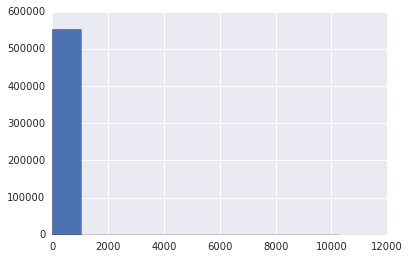

In [14]:
plt.hist(users.review_count)
plt.show()

In [11]:
users.review_count.describe()

count    552339.000000
mean         27.631737
std          87.741127
min           0.000000
25%           2.000000
50%           6.000000
75%          18.000000
max       10320.000000
Name: review_count, dtype: float64

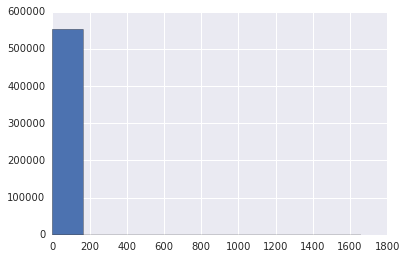

In [8]:
plt.hist(users.fans);

In [15]:
users.fans.describe()

count    552339.000000
mean          1.331508
std          10.798539
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1657.000000
Name: fans, dtype: float64

In [57]:
reviewcsv = pd.read_csv('data/yelp_academic_dataset_review.csv')

In [71]:
reviewcsv.head()

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful
0,PUFPaY9KxDAcGqfsorJp3Q,Ya85v4eqdd6k9Od8HbQjyA,"Mr Hoagie is an institution. Walking in, it do...",0,5UmKMjUEUNdYWqANhGckJw,0,4,2012-08-01,review,0
1,Iu6AxdBYGR4A0wspR9BYHA,KPvLNJ21_4wbYNctrOwWdQ,Excellent food. Superb customer service. I mis...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2014-02-13,review,0
2,auESFwWvW42h6alXgFxAXQ,fFSoGV46Yxuwbr3fHNuZig,Yes this place is a little out dated and not o...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2015-10-31,review,0
3,uK8tzraOp4M5u3uYrqIBXg,Di3exaUCFNw1V4kSNW5pgA,All the food is great here. But the best thing...,0,UsFtqoBl7naz8AVUBZMjQQ,0,5,2013-11-08,review,0
4,I_47G-R2_egp7ME5u_ltew,0Lua2-PbqEQMjD9r89-asw,We checked this place out this past Monday for...,0,UsFtqoBl7naz8AVUBZMjQQ,0,3,2014-03-29,review,0


In [70]:
reviewcsv.loc[0, 'text']

'Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.'